Implementing Agglomerative Clustering in smaller chunks to avoid memory issues. This involves dividing data into smaller batches and clustering each batch separately.

Unfortunately, sklearn's AgglomerativeClustering does not support incremental fitting out of the box. Instead, I will have to manually handle chunks by clustering each chunk separately and then merging the results. This approach may not be as accurate as clustering the entire dataset at once, but it helps avoid memory errors.



Here's how I implement this:
Chunk Processing:
1. Divide the dataset into smaller chunks.
2. Perform clustering on each chunk.
3. Combine the clustering results.

Here is more Explanation
1. Chunk Processing: The process_chunks function processes the data in chunks of size chunk_size. Each chunk is clustered separately using Agglomerative Clustering.
2. Combining Results: The results from each chunk are combined into a single array. The cluster labels are adjusted to ensure they are unique across different chunks.
3. Silhouette Score: The silhouette score is calculated for the entire dataset using the combined cluster labels.
4. Visualization: The results are visualized in 2D and 3D scatter plots to show the clustering results.
Notes
5. Adjust Parameters: Adjust the chunk_size and n_clusters parameters based on your specific dataset and requirements.
6. Resource Monitoring: Monitor system resources during execution to ensure the code runs smoothly without exhausting system memory.

This approach helpped me in handling large datasets by clustering smaller chunks sequentially and then combining the results.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
# Ensure plots are displayed inline
%matplotlib inline

print("All libraries imported successfully!")

All libraries imported successfully!


In [3]:

# Load the main dataset
data_path = 'data2.csv'  # Adjust the path if necessary
data = pd.read_csv(data_path)
data = pd.get_dummies(data, columns=[])

# Load your selected columns from the specified path
selected_columns_path = 'AirEau_features_lag15.csv'  # Adjust the path if necessary
selected_columns_df = pd.read_csv(selected_columns_path)

# Select only the feature column
selected_columns = selected_columns_df['Feature'].tolist()

# Select the data for analysis
data_selected = data[selected_columns]

# Check if the first column is date and time, and drop it if necessary
if 'Date' in data_selected.columns or 'Time' in data_selected.columns:
    data_selected = data_selected.drop(columns=['Date', 'Time'], errors='ignore')

In [4]:
# Preprocess the data
X = data_selected.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the maximum allowable number of PCA components
max_components = min(X_scaled.shape)

# Perform PCA
n_components = min(40, max_components)
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

In [9]:
# Define a function to process data in chunks
def process_chunks(X, chunk_size=1000, n_clusters=3):
    """
    Processes the data in chunks, performs Agglomerative Clustering on each chunk,
    and combines the results.

    Parameters:
    - X: ndarray, the input data to be clustered
    - chunk_size: int, the size of each chunk to process
    - n_clusters: int, the number of clusters to find

    Returns:
    - y_agg_all: ndarray, the combined cluster labels for the entire dataset
    """
    n_samples = X.shape[0]
    y_agg_all = np.empty(n_samples, dtype=int)  # Initialize an array to store cluster labels
    
    for start in range(0, n_samples, chunk_size):
        end = min(start + chunk_size, n_samples)  # Define the end of the current chunk
        X_chunk = X[start:end]  # Extract the current chunk
        
        # Perform Agglomerative clustering on the chunk
        agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
        y_agg_chunk = agglomerative.fit_predict(X_chunk)
        
        # Store the results, adjusting labels to be unique across chunks
        y_agg_all[start:end] = y_agg_chunk + (start // chunk_size) * n_clusters
        
    return y_agg_all

In [6]:
# Process the data in chunks
chunk_size = 1000  # Adjust as needed based on memory capacity
n_clusters = 3  # Adjust as needed based on the desired number of clusters
y_agg = process_chunks(X_pca, chunk_size=chunk_size, n_clusters=n_clusters)

# Calculate Silhouette Score for the entire dataset
silhouette_avg_agg = silhouette_score(X_pca, y_agg)
print(f'Agglomerative Clustering Silhouette Score: {silhouette_avg_agg:.2f}')

Agglomerative Clustering Silhouette Score: -0.06


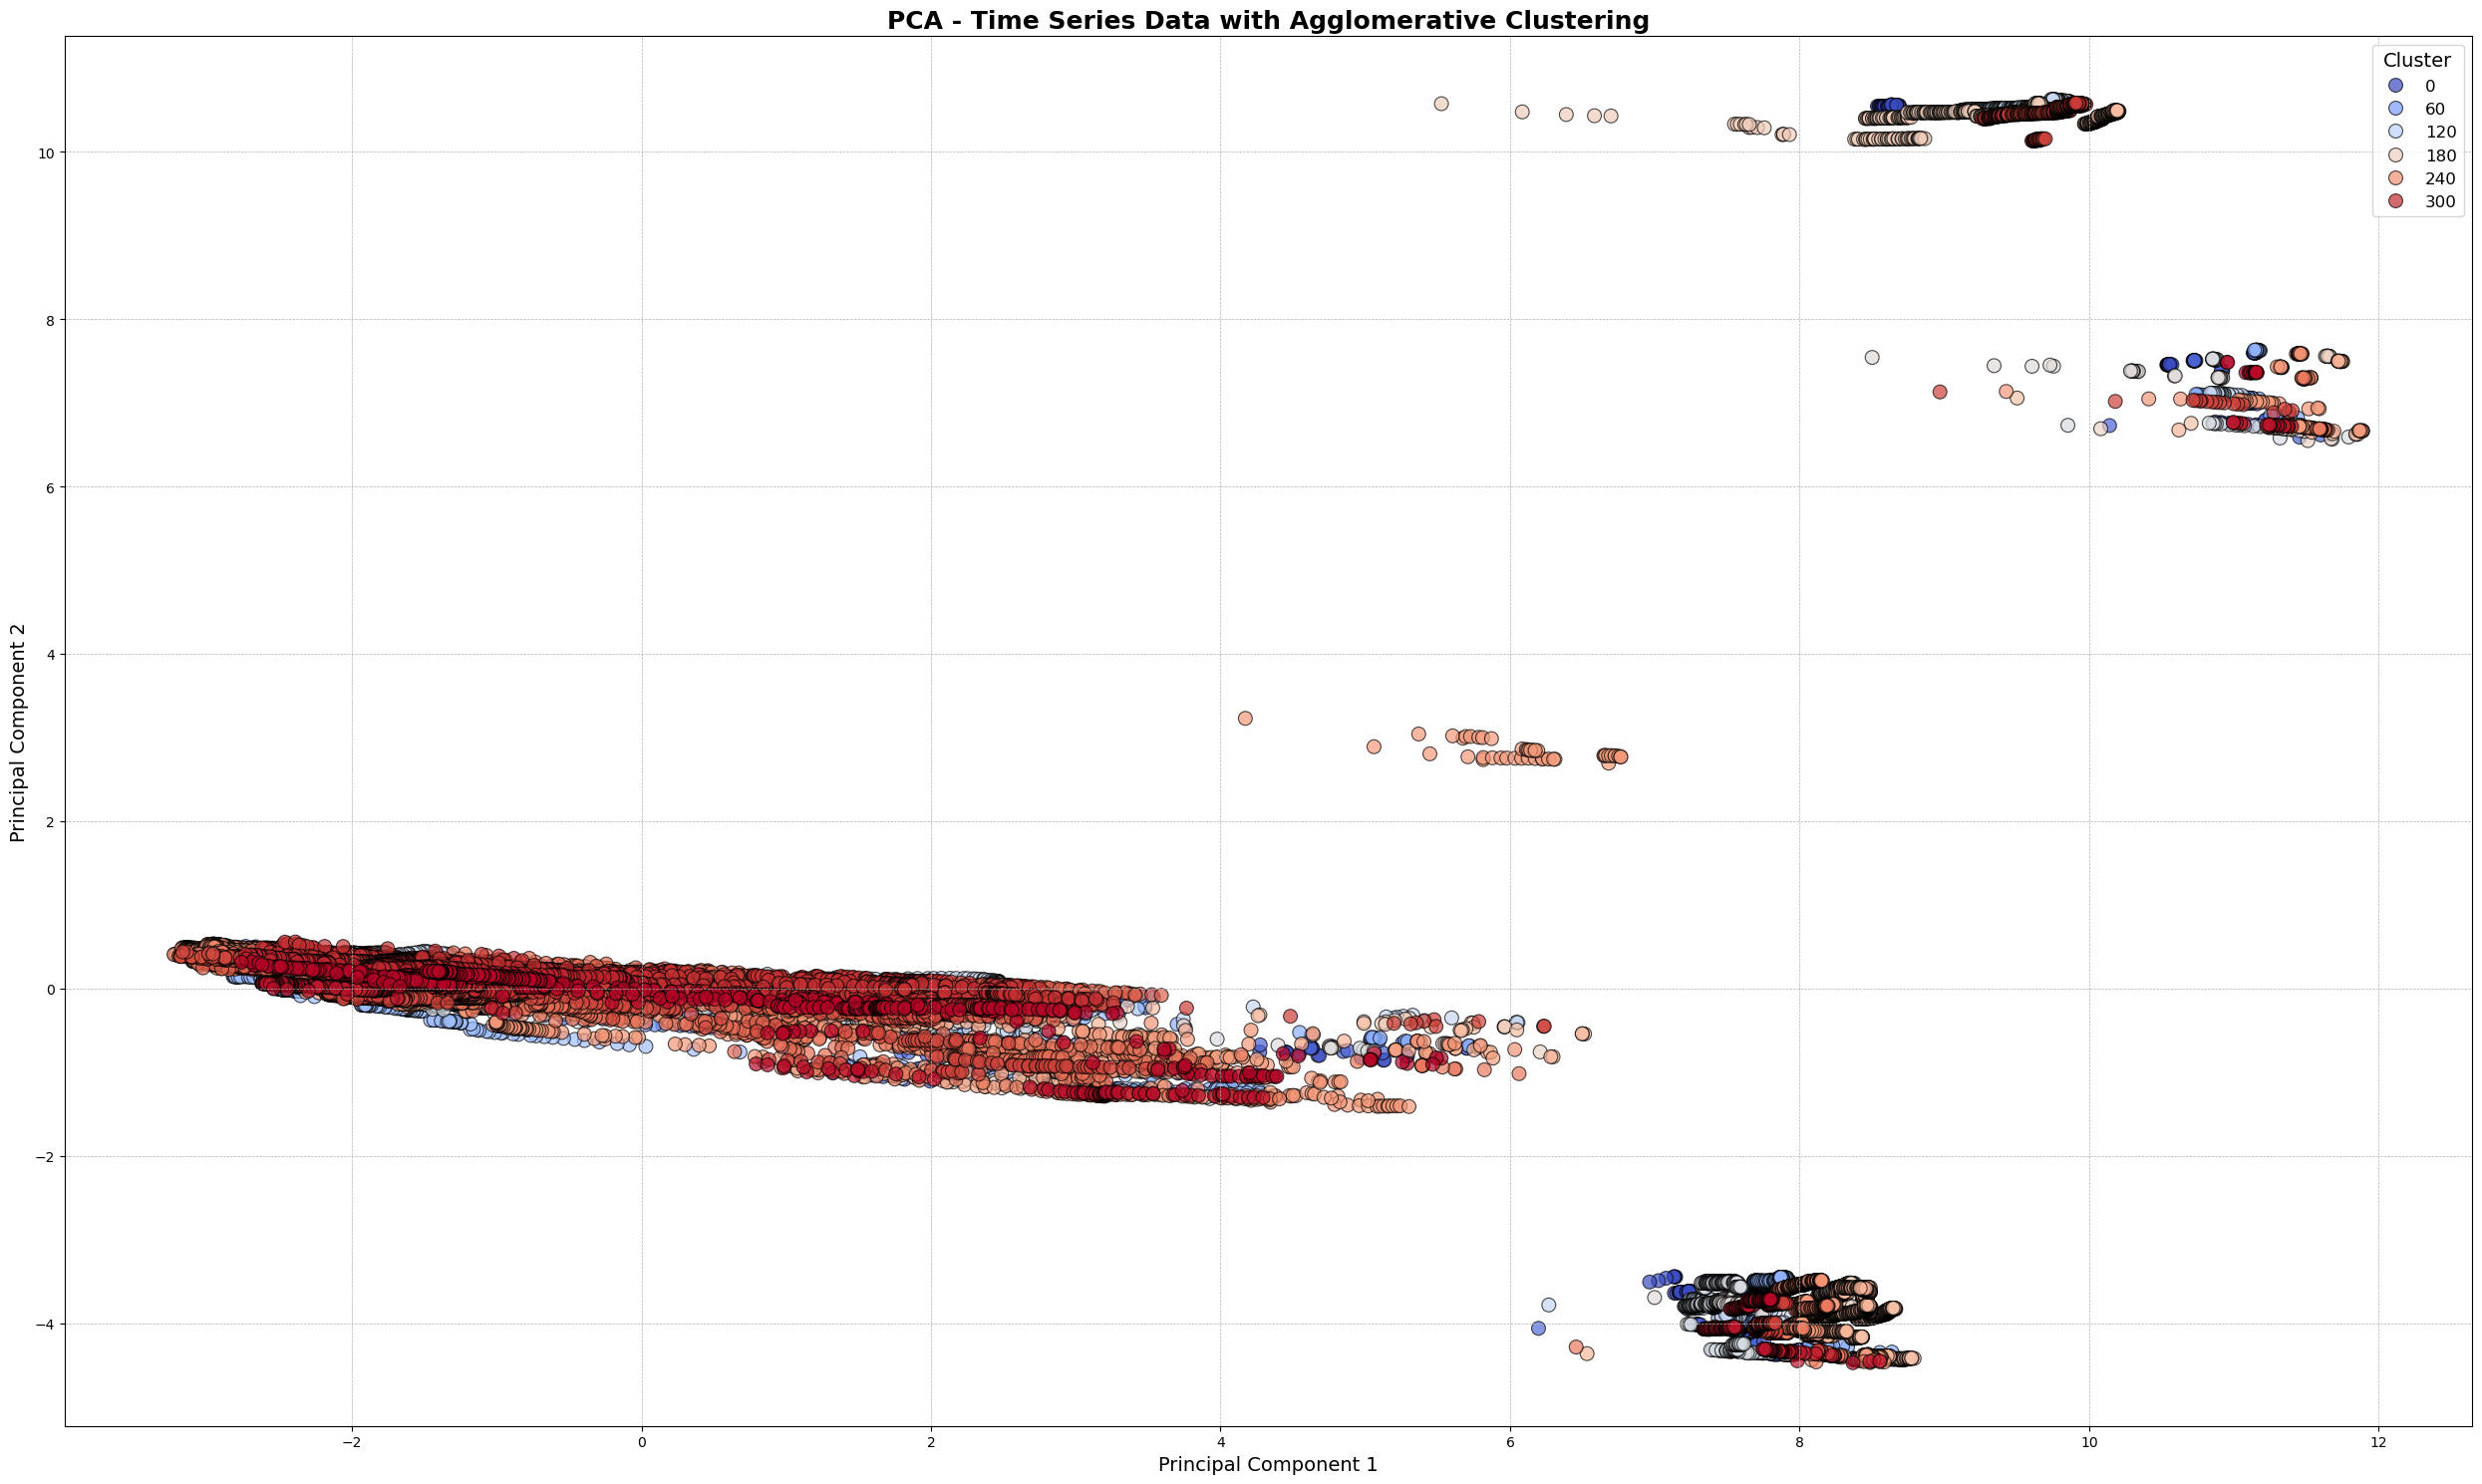

In [15]:
# Visualize clustering results in 2D
plt.figure(figsize=(25, 15))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_agg, palette='coolwarm', s=100, alpha=0.7, edgecolor='k')
plt.title('PCA - Time Series Data with Agglomerative Clustering', fontsize=18, weight='bold')
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.legend(title='Cluster', fontsize=12, title_fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

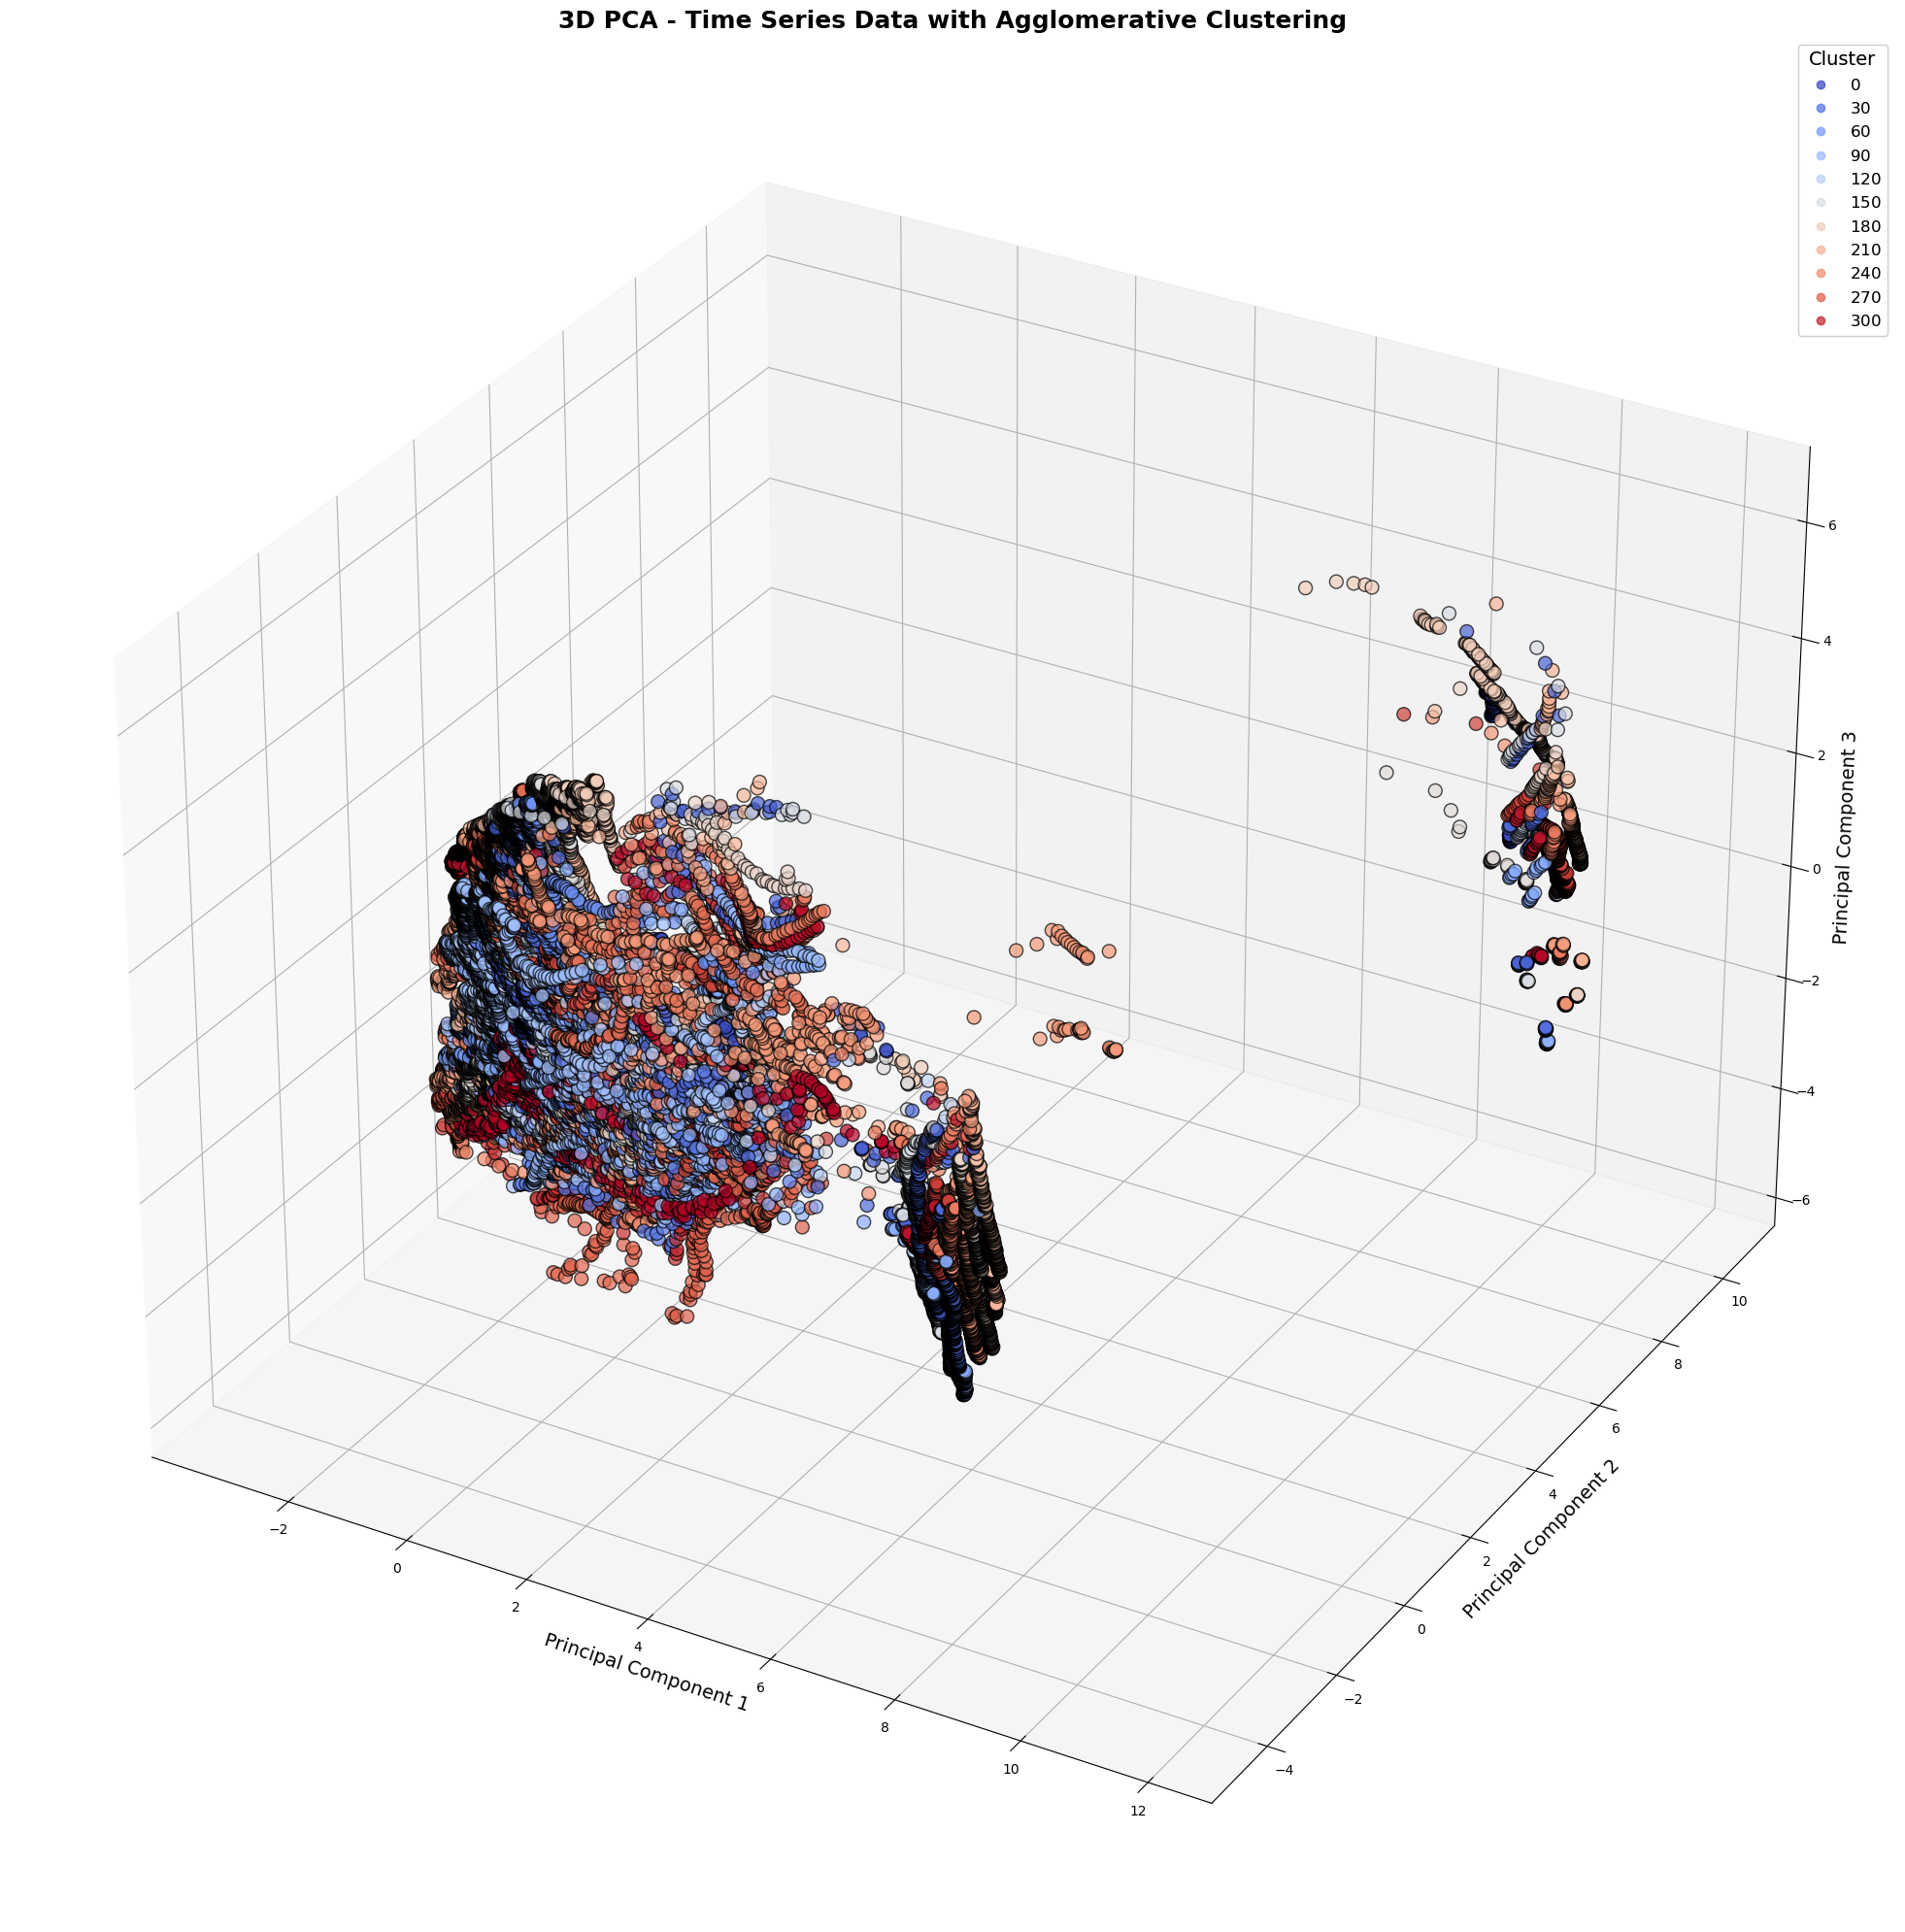

In [12]:
# Visualize clustering results in 3D
fig = plt.figure(figsize=(25, 20))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y_agg, cmap='coolwarm', s=100, alpha=0.7, edgecolor='k')
legend1 = ax.legend(*scatter.legend_elements(), title="Cluster", fontsize=12, title_fontsize=14)
ax.add_artist(legend1)
ax.set_title('3D PCA - Time Series Data with Agglomerative Clustering', fontsize=18, weight='bold')
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)
ax.set_zlabel('Principal Component 3', fontsize=14)
ax.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
